In [1]:
# Import Required Libraries
from pathlib import Path
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
import random
import numpy as np
import pandas as pd

In [2]:
# Direktori gambar
train_dir = "images/training/"
test_dir = "images/test/"

In [3]:
def load_dataset(img_dir):  # Mendefinisikan fungsi load_dataset dengan parameter img_dir
    p = Path(img_dir)  # Membuat objek Path dari img_dir
    dirs = p.glob('*')  # Mendapatkan semua subdirektori di dalam img_dir

    img_list = []  # Menginisialisasi list kosong untuk menyimpan pasangan gambar dan label

    for dir in dirs:  # Loop untuk setiap subdirektori
        label = str(dir).split('\\')[-1]  # Mengambil nama subdirektori sebagai label
        for file in dir.glob('*.jpg'):  # Loop untuk setiap file gambar dengan ekstensi .jpg
            img = mpimg.imread(file)  # Membaca gambar menggunakan mpimg.imread

            if not img is None:  # Memeriksa apakah gambar berhasil dibaca
                img_list.append((img, label))  # Menambahkan pasangan (gambar, label) ke dalam img_list
    
    return img_list  # Mengembalikan img_list yang berisi semua gambar dan label


In [4]:
# Load training data
train_img = load_dataset(train_dir)

# Load test data
test_img = load_dataset(test_dir)

In [5]:
def standarized_input(image):
    # resize to w: 1100, h:600
    std_img = cv2.resize(image, (1100,600))

    return std_img

In [6]:
def label_encoder(label):
    # Encode the label
    # day as 1; night as 0
    num_val = 0

    if(label == 'day'):
        num_val = 1
    
    return num_val

In [7]:
def preprocess(img_list):  # Mendefinisikan fungsi preprocess dengan parameter img_list
    std_img_list = []  # Menginisialisasi list kosong untuk menyimpan pasangan gambar dan label yang telah distandarisasi

    for item in img_list:  # Loop untuk setiap item dalam img_list
        image = item[0]  # Mengambil gambar dari item
        label = item[1]  # Mengambil label dari item

        # Standarized the image
        std_img = standarized_input(image)  # Menstandarisasi gambar menggunakan fungsi standarized_input

        # Create the label
        img_label = label_encoder(label)  # Mengenkode label menggunakan fungsi label_encoder

        std_img_list.append((std_img, img_label))  # Menambahkan pasangan (gambar yang distandarisasi, label yang dienkode) ke dalam std_img_list
    
    return std_img_list  # Mengembalikan std_img_list yang berisi semua gambar dan label yang telah diproses


In [8]:
train_std_img_list = preprocess(train_img)
test_std_img_list = preprocess(test_img)

In [19]:
def brightness_histogram(image, bins=256, range=(0, 256)):  
    # Fungsi untuk menghitung histogram kecerahan (brightness) dari sebuah gambar, 
    # dengan jumlah bin (interval) default 256 dan range kecerahan dari 0 sampai 256

    # Convert image to HSV
    img_hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)  
    # Mengonversi gambar dari format RGB ke HSV. HSV adalah format warna yang memisahkan Hue (warna), Saturation (kejenuhan), dan Value (kecerahan)

    # Extract the V channel (brightness)
    brightness = img_hsv[:, :, 2]  
    # Mengekstrak channel V (Value), yang mewakili kecerahan dari gambar dalam format HSV

    # Calculate histogram for the V channel
    hist = cv2.calcHist([brightness], [0], None, [bins], range)  
    # Menghitung histogram dari channel kecerahan (V). Histogram ini memiliki jumlah bin tertentu dan rentang kecerahan dari 0 hingga 256

    # Normalize the histogram
    hist = hist / hist.sum()  
    # Menormalkan histogram agar total semua nilainya menjadi 1, sehingga dapat diinterpretasikan sebagai distribusi probabilitas

    return hist
    # Mengembalikan histogram kecerahan yang sudah dinormalisasi


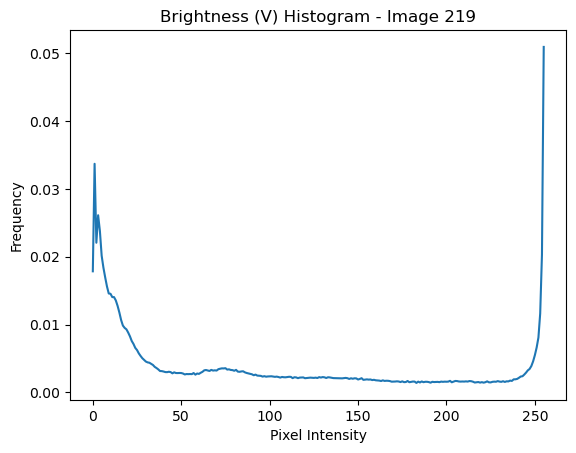

In [20]:
# Check on random image
rand_img = np.random.randint(0, len(train_std_img_list))  
# Memilih sebuah indeks acak dari `train_std_img_list`, yang merupakan list dari gambar yang sudah di-standarkan (normalized)

feature_img = train_std_img_list[rand_img][0]  
# Mengambil gambar berdasarkan indeks acak yang dipilih. `train_std_img_list[rand_img][0]` mengambil elemen pertama dari tuple (gambar, label)

brightness_histogram_img = brightness_histogram(feature_img)  
# Menghitung histogram kecerahan (brightness) dari gambar acak yang dipilih menggunakan fungsi `brightness_histogram`

plt.plot(brightness_histogram_img)  
# Membuat grafik dari histogram kecerahan yang sudah dihitung menggunakan `matplotlib.pyplot.plot()`
plt.title(f"Brightness (V) Histogram - Image {rand_img}")
# Menambahkan judul pada grafik "Brightness (V) Histogram"
plt.xlabel("Pixel Intensity")  
# Menambahkan label sumbu x "Pixel Intensity" yang merepresentasikan intensitas kecerahan dari 0 hingga 255
plt.ylabel("Frequency")  
# Menambahkan label sumbu y "Frequency" yang merepresentasikan frekuensi kemunculan intensitas pixel tertentu dalam gambar
plt.show()  
# Menampilkan grafik histogram kecerahan


In [21]:
def extract_brightness_histogram_feature(img_list):
    hist_list = []  # List untuk menyimpan histogram kecerahan setiap gambar
    labels = []  # List untuk menyimpan label dari setiap gambar

    for img in img_list:
        img_hist = brightness_histogram(img[0])  # Dapatkan histogram kecerahan dari gambar
        img_label = img[1]  # Dapatkan label gambar

        hist_list.append(img_hist.flatten())  # Ubah histogram dari bentuk multi-dimensi menjadi array 1D
        labels.append(img_label)  # Simpan label gambar
    
    # Stack data in columnar way
    hist_array = np.array(hist_list)  # Konversi list histogram menjadi array numpy
    data = np.column_stack((hist_array, labels))  # Menyusun histogram dan label secara berdampingan sebagai kolom

    # Create a Pandas dataframe
    column_names = [f'Bin_{i}' for i in range(hist_array.shape[1])] + ['LABELS']  # Menamai kolom untuk setiap bin histogram
    df = pd.DataFrame(data, columns=column_names)  # Membuat DataFrame pandas dengan histogram dan label sebagai kolom

    return df  # Mengembalikan DataFrame


In [22]:
# Extract feature on train data
train_hist_img = extract_brightness_histogram_feature(train_std_img_list)
print(f'Shape: {train_hist_img.shape}')  # Menampilkan ukuran DataFrame
train_hist_img.head()  # Menampilkan 5 baris pertama dari DataFrame


Shape: (240, 257)


,Bin_0,Bin_1,Bin_2,Bin_3,Bin_4,Bin_5,Bin_6,Bin_7,Bin_8,Bin_9,...,Bin_247,Bin_248,Bin_249,Bin_250,Bin_251,Bin_252,Bin_253,Bin_254,Bin_255,LABELS
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000048,0.000044,0.000042,0.000032,0.000030,0.000035,0.000033,0.000039,0.000029,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000259,0.000315,0.000420,0.000309,0.000267,0.000202,0.000161,0.000197,0.000147,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.001067,0.001253,0.001400,0.001629,0.001968,0.002191,0.002700,0.003608,0.007095,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000179,0.000185,0.000150,0.000120,0.000150,0.000147,0.000115,0.000106,0.000080,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000048,0.000030,0.000042,0.000014,0.000021,0.000011,0.000012,0.000011,0.000002,1.0


In [23]:
# Extract feature on test data
test_hist_img = extract_brightness_histogram_feature(test_std_img_list)
print(f'Shape: {test_hist_img.shape}')
test_hist_img.head()

Shape: (160, 257)


,Bin_0,Bin_1,Bin_2,Bin_3,Bin_4,Bin_5,Bin_6,Bin_7,Bin_8,Bin_9,...,Bin_247,Bin_248,Bin_249,Bin_250,Bin_251,Bin_252,Bin_253,Bin_254,Bin_255,LABELS
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000105,0.000061,0.000071,0.000095,0.000083,0.000088,0.000076,0.000061,0.000068,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.003171,0.003474,0.003770,0.004370,0.005552,0.008476,0.009736,0.013476,0.021748,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000195,0.000142,0.000153,0.000174,0.000205,0.000209,0.000227,0.000194,0.000173,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000273,0.000230,0.000174,0.000177,0.000120,0.000139,0.000139,0.000106,0.000056,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000252,0.000239,0.000217,0.000174,0.000194,0.000180,0.000148,0.000126,0.000088,1.0


In [24]:
from sklearn.svm import SVC

# Mengambil semua kolom kecuali kolom terakhir untuk fitur
X_train = train_hist_img.iloc[:, :-1].values  # Semua kolom kecuali LABELS
y_train = train_hist_img['LABELS'].values  # Kolom LABELS
X_test = test_hist_img.iloc[:, :-1].values # Semua kolom kecuali LABELS
y_test = test_hist_img['LABELS'].values # Kolom LABELS


# Buat dan latih model SVC
model = SVC(kernel='poly') 
model.fit(X_train, y_train)   # Melatih model

SVC(kernel='poly')

In [26]:
from sklearn.metrics import accuracy_score

# Make a prediction on train data
y_train_pred = model.predict(X_train)  # Menggunakan model yang sudah dilatih untuk memprediksi data latih (X_train)

# Get the accuracy on train data
acc_train = accuracy_score(y_train, y_train_pred)  # Menghitung akurasi prediksi pada data latih (y_train_pred) dibandingkan dengan label aslinya (y_train)

# Make a prediction on test data
y_test_pred = model.predict(X_test)  # Menggunakan model untuk memprediksi data uji (X_test)

# Get the accuracy on test data
acc_test = accuracy_score(y_test, y_test_pred)  # Menghitung akurasi prediksi pada data uji (y_test_pred) dibandingkan dengan label aslinya (y_test)

# Print Eval Result
print(f'Accuracy on train: {acc_train}')
print(f'Accuracy on test: {acc_test}')

Accuracy on train: 0.9958333333333333
Accuracy on test: 0.98125
